In [1]:
import numpy as np
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

print(keras.__version__)
from numpy.random import seed
seed(123)

2022-05-27 22:58:57.867868: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-27 22:58:57.867891: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.9.1
2.9.0


# Zad
Porównaj wyniki działań różnych optymalizacji
* 
```python
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False)
```
* 
```python
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
```
* 
```python
RMSprop = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
```
* 
```python
Adagrad = keras.optimizers.Adagrad(learning_rate=0.01)
```
* 
```python
Adadelta = keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)
```
* 
```python
Adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
```
* 
```python
Adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
```

https://keras.io/optimizers/

In [3]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('data/adult/adult.data', sep=", ",header = None)
test_set = pd.read_csv('data/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()


/tmp/ipykernel_1167890/4098396877.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_set = pd.read_csv('data/adult/adult.data', sep=", ",header = None)
/tmp/ipykernel_1167890/4098396877.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test_set = pd.read_csv('data/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(30162, 41)
(15060, 41)


# SGD

In [5]:
from keras.models import Sequential
from keras.layers import Dense

from keras.callbacks import History

history_sgd = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4200      
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________


In [6]:
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="binary_crossentropy",optimizer=sgd, metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [7]:
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[history_sgd])

Epoch 1/100
498/498 [==============================] - 5s 7ms/step - loss: 0.5531 - accuracy: 0.7531 - val_loss: 0.5351 - val_accuracy: 0.7543
Epoch 2/100
498/498 [==============================] - 1s 3ms/step - loss: 0.4690 - accuracy: 0.7669 - val_loss: 0.3799 - val_accuracy: 0.8282
Epoch 3/100
498/498 [==============================] - 1s 3ms/step - loss: 0.3593 - accuracy: 0.8331 - val_loss: 0.3461 - val_accuracy: 0.8399
Epoch 4/100
498/498 [==============================] - 1s 3ms/step - loss: 0.3461 - accuracy: 0.8376 - val_loss: 0.3400 - val_accuracy: 0.8420
Epoch 5/100
498/498 [==============================] - 1s 3ms/step - loss: 0.3410 - accuracy: 0.8391 - val_loss: 0.3376 - val_accuracy: 0.8428
Epoch 6/100
498/498 [==============================] - 1s 3ms/step - loss: 0.3382 - accuracy: 0.8428 - val_loss: 0.3385 - val_accuracy: 0.8394
Epoch 7/100
498/498 [==============================] - 1s 3ms/step - loss: 0.3356 - accuracy: 0.8414 - val_loss: 0.3355 - val_accuracy: 0.8414

In [8]:
history_sgd.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

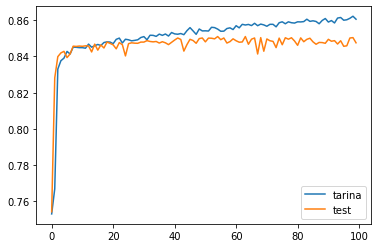

In [9]:
import matplotlib.pyplot as pl
plt.plot(history_sgd.history['accuracy'], label = "tarina")
plt.plot(history_sgd.history['val_accuracy'], label = "test")
plt.legend()
plt.show()

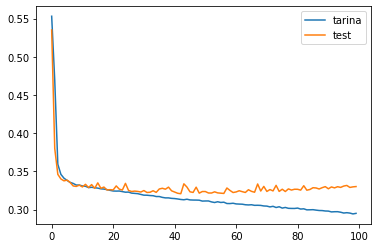

In [10]:
import matplotlib.pyplot as pl
plt.plot(history_sgd.history['loss'], label = "tarina")
plt.plot(history_sgd.history['val_loss'], label = "test")
plt.legend()
plt.show()

# RMSprop

In [13]:
history_RMSprop = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()
RMSprop = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
model.compile(loss="binary_crossentropy",optimizer=RMSprop, metrics=["accuracy"])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 100)               4200      
                                                                 
 dense_9 (Dense)             (None, 50)                5050      
                                                                 
 dense_10 (Dense)            (None, 10)                510       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[history_RMSprop])

Epoch 1/100
498/498 [==============================] - 2s 3ms/step - loss: 0.4004 - accuracy: 0.8138 - val_loss: 0.3512 - val_accuracy: 0.8382
Epoch 2/100
498/498 [==============================] - 1s 3ms/step - loss: 0.3486 - accuracy: 0.8386 - val_loss: 0.3430 - val_accuracy: 0.8412
Epoch 3/100
498/498 [==============================] - 1s 3ms/step - loss: 0.3417 - accuracy: 0.8420 - val_loss: 0.3377 - val_accuracy: 0.8451
Epoch 4/100
498/498 [==============================] - 1s 3ms/step - loss: 0.3387 - accuracy: 0.8431 - val_loss: 0.3365 - val_accuracy: 0.8465
Epoch 5/100
498/498 [==============================] - 2s 3ms/step - loss: 0.3357 - accuracy: 0.8454 - val_loss: 0.3346 - val_accuracy: 0.8471
Epoch 6/100
498/498 [==============================] - 2s 5ms/step - loss: 0.3334 - accuracy: 0.8456 - val_loss: 0.3344 - val_accuracy: 0.8459
Epoch 7/100
498/498 [==============================] - 2s 4ms/step - loss: 0.3320 - accuracy: 0.8460 - val_loss: 0.3313 - val_accuracy: 0.8483

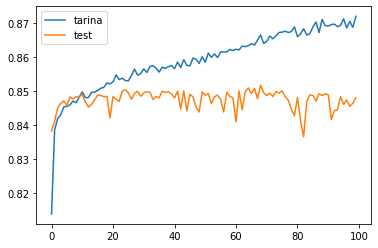

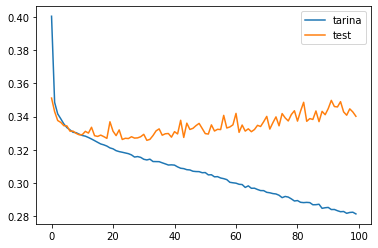

In [15]:
plt.plot(history_RMSprop.history['accuracy'], label = "tarina")
plt.plot(history_RMSprop.history['val_accuracy'], label = "test")
plt.legend()
plt.show()
plt.plot(history_RMSprop.history['loss'], label = "tarina")
plt.plot(history_RMSprop.history['val_loss'], label = "test")
plt.legend()
plt.show()

# Adagrad

In [18]:
history_Adagrad = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()
Adagrad = keras.optimizers.Adagrad(learning_rate=0.01)
model.compile(loss="binary_crossentropy",optimizer=Adagrad, metrics=["accuracy"])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 100)               4200      
                                                                 
 dense_17 (Dense)            (None, 50)                5050      
                                                                 
 dense_18 (Dense)            (None, 10)                510       
                                                                 
 dense_19 (Dense)            (None, 1)                 11        
                                                                 
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[history_Adagrad])

Epoch 1/100
498/498 [==============================] - 2s 3ms/step - loss: 0.6030 - accuracy: 0.7036 - val_loss: 0.5553 - val_accuracy: 0.7543
Epoch 2/100
498/498 [==============================] - 1s 3ms/step - loss: 0.5555 - accuracy: 0.7531 - val_loss: 0.5531 - val_accuracy: 0.7543
Epoch 3/100
498/498 [==============================] - 1s 3ms/step - loss: 0.5531 - accuracy: 0.7531 - val_loss: 0.5502 - val_accuracy: 0.7543
Epoch 4/100
498/498 [==============================] - 1s 3ms/step - loss: 0.5497 - accuracy: 0.7531 - val_loss: 0.5462 - val_accuracy: 0.7543
Epoch 5/100
498/498 [==============================] - 1s 3ms/step - loss: 0.5445 - accuracy: 0.7531 - val_loss: 0.5396 - val_accuracy: 0.7543
Epoch 6/100
498/498 [==============================] - 1s 3ms/step - loss: 0.5358 - accuracy: 0.7531 - val_loss: 0.5286 - val_accuracy: 0.7543
Epoch 7/100
498/498 [==============================] - 1s 3ms/step - loss: 0.5211 - accuracy: 0.7531 - val_loss: 0.5098 - val_accuracy: 0.7543

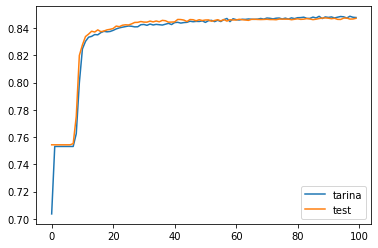

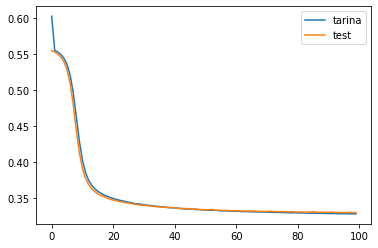

In [20]:
plt.plot(history_Adagrad.history['accuracy'], label = "tarina")
plt.plot(history_Adagrad.history['val_accuracy'], label = "test")
plt.legend()
plt.show()
plt.plot(history_Adagrad.history['loss'], label = "tarina")
plt.plot(history_Adagrad.history['val_loss'], label = "test")
plt.legend()
plt.show()

# Adadelta

In [30]:
history_Adadelta = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()
Adadelta = keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)
model.compile(loss="binary_crossentropy",optimizer=Adadelta, metrics=["accuracy"])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 100)               4200      
                                                                 
 dense_33 (Dense)            (None, 50)                5050      
                                                                 
 dense_34 (Dense)            (None, 10)                510       
                                                                 
 dense_35 (Dense)            (None, 1)                 11        
                                                                 
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[history_Adadelta])

Epoch 1/100
498/498 [==============================] - 2s 3ms/step - loss: 0.4483 - accuracy: 0.7887 - val_loss: 0.3616 - val_accuracy: 0.8327
Epoch 2/100
498/498 [==============================] - 1s 3ms/step - loss: 0.3562 - accuracy: 0.8325 - val_loss: 0.3518 - val_accuracy: 0.8407
Epoch 3/100
498/498 [==============================] - 1s 3ms/step - loss: 0.3470 - accuracy: 0.8385 - val_loss: 0.3407 - val_accuracy: 0.8430
Epoch 4/100
498/498 [==============================] - 1s 3ms/step - loss: 0.3419 - accuracy: 0.8397 - val_loss: 0.3376 - val_accuracy: 0.8443
Epoch 5/100
498/498 [==============================] - 1s 3ms/step - loss: 0.3380 - accuracy: 0.8421 - val_loss: 0.3352 - val_accuracy: 0.8466
Epoch 6/100
498/498 [==============================] - 1s 3ms/step - loss: 0.3362 - accuracy: 0.8434 - val_loss: 0.3327 - val_accuracy: 0.8471
Epoch 7/100
498/498 [==============================] - 1s 3ms/step - loss: 0.3339 - accuracy: 0.8443 - val_loss: 0.3330 - val_accuracy: 0.8469

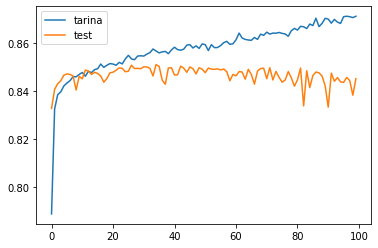

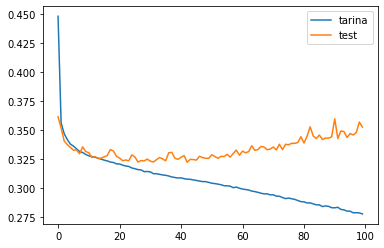

In [23]:
plt.plot(history_Adadelta.history['accuracy'], label = "tarina")
plt.plot(history_Adadelta.history['val_accuracy'], label = "test")
plt.legend()
plt.show()
plt.plot(history_Adadelta.history['loss'], label = "tarina")
plt.plot(history_Adadelta.history['val_loss'], label = "test")
plt.legend()
plt.show()

# Adam

In [24]:
history_Adam1 = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()
Adam1 = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="binary_crossentropy",optimizer=Adam1, metrics=["accuracy"])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 100)               4200      
                                                                 
 dense_25 (Dense)            (None, 50)                5050      
                                                                 
 dense_26 (Dense)            (None, 10)                510       
                                                                 
 dense_27 (Dense)            (None, 1)                 11        
                                                                 
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[history_Adam1])

Epoch 1/100
498/498 [==============================] - 2s 4ms/step - loss: 0.4576 - accuracy: 0.7969 - val_loss: 0.3740 - val_accuracy: 0.8380
Epoch 2/100
498/498 [==============================] - 2s 3ms/step - loss: 0.3615 - accuracy: 0.8381 - val_loss: 0.3521 - val_accuracy: 0.8377
Epoch 3/100
498/498 [==============================] - 2s 3ms/step - loss: 0.3447 - accuracy: 0.8425 - val_loss: 0.3475 - val_accuracy: 0.8436
Epoch 4/100
498/498 [==============================] - 2s 3ms/step - loss: 0.3379 - accuracy: 0.8441 - val_loss: 0.3342 - val_accuracy: 0.8467
Epoch 5/100
498/498 [==============================] - 2s 3ms/step - loss: 0.3330 - accuracy: 0.8454 - val_loss: 0.3299 - val_accuracy: 0.8483
Epoch 6/100
498/498 [==============================] - 2s 3ms/step - loss: 0.3299 - accuracy: 0.8483 - val_loss: 0.3297 - val_accuracy: 0.8477
Epoch 7/100
498/498 [==============================] - 2s 3ms/step - loss: 0.3273 - accuracy: 0.8488 - val_loss: 0.3277 - val_accuracy: 0.8475

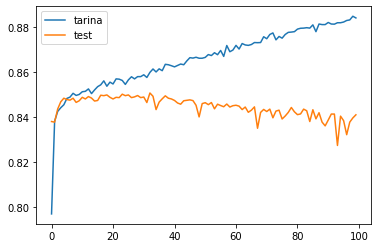

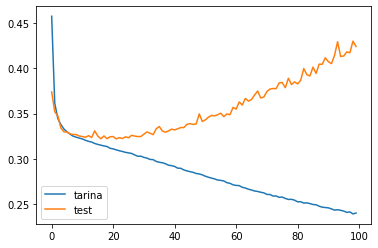

In [26]:
plt.plot(history_Adam1.history['accuracy'], label = "tarina")
plt.plot(history_Adam1.history['val_accuracy'], label = "test")
plt.legend()
plt.show()
plt.plot(history_Adam1.history['loss'], label = "tarina")
plt.plot(history_Adam1.history['val_loss'], label = "test")
plt.legend()
plt.show()

# Adam

In [27]:
history_Adam2 = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()
Adam2 = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="binary_crossentropy",optimizer=Adam2, metrics=["accuracy"])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 100)               4200      
                                                                 
 dense_29 (Dense)            (None, 50)                5050      
                                                                 
 dense_30 (Dense)            (None, 10)                510       
                                                                 
 dense_31 (Dense)            (None, 1)                 11        
                                                                 
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[history_Adam2])

Epoch 1/100
498/498 [==============================] - 2s 3ms/step - loss: 0.4586 - accuracy: 0.7806 - val_loss: 0.3653 - val_accuracy: 0.8412
Epoch 2/100
498/498 [==============================] - 2s 3ms/step - loss: 0.3548 - accuracy: 0.8380 - val_loss: 0.3444 - val_accuracy: 0.8425
Epoch 3/100
498/498 [==============================] - 1s 3ms/step - loss: 0.3421 - accuracy: 0.8413 - val_loss: 0.3371 - val_accuracy: 0.8445
Epoch 4/100
498/498 [==============================] - 1s 3ms/step - loss: 0.3356 - accuracy: 0.8446 - val_loss: 0.3369 - val_accuracy: 0.8457
Epoch 5/100
498/498 [==============================] - 1s 3ms/step - loss: 0.3316 - accuracy: 0.8466 - val_loss: 0.3298 - val_accuracy: 0.8485
Epoch 6/100
498/498 [==============================] - 1s 3ms/step - loss: 0.3286 - accuracy: 0.8469 - val_loss: 0.3312 - val_accuracy: 0.8465
Epoch 7/100
498/498 [==============================] - 1s 3ms/step - loss: 0.3262 - accuracy: 0.8492 - val_loss: 0.3268 - val_accuracy: 0.8477

KeyError: ignored

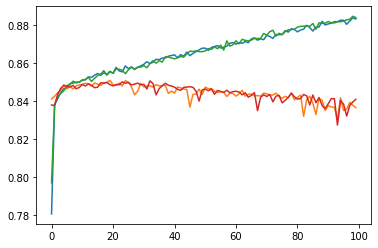

In [32]:
plt.plot(history_Adam2.history['accuracy'], label = "tarina Adam2")
plt.plot(history_Adam2.history['val_accuracy'], label = "test Adam2")
plt.plot(history_Adam1.history['accuracy'], label = "tarina Adam1")
plt.plot(history_Adam1.history['val_accuracy'], label = "test Adam1")
plt.plot(history_Adadelta.history['accuracy'], label = "tarina")
plt.plot(history_Adadelta.history['val_accuracy'], label = "test")
plt.legend()
plt.show()
plt.plot(history_Adam2.history['loss'], label = "tarinaAdam2")
plt.plot(history_Adam2.history['val_loss'], label = "testAdam2")
plt.plot(history_Adam1.history['loss'], label = "tarinaAdam1")
plt.plot(history_Adam1.history['val_loss'], label = "testAdam1")
plt.plot(history_Adadelta.history['loss'], label = "tarina")
plt.plot(history_Adadelta.history['val_loss'], label = "test")
plt.legend()
plt.show()